##### - Importando as Bibliotecas necessárias ⇩

In [1]:
import numpy as np      
import pandas as pd     
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import FuncFormatter 

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")


##### - Importando os DataFrames ⇩

In [2]:
df_store = pd.read_csv('stores.csv')
df_train = pd.read_csv('train.csv')
df_features = pd.read_csv('features.csv')
df_test = pd.read_csv('test.csv')

In [3]:
# - Deixando um limite de 100 linhas para display do df. ⇩
pd.options.display.max_columns=100 

##### - Primeira Análise exploratoria dos dados ⇩

In [4]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


##### - Juntando os 3 datasets(store, train e features) ⇩

In [7]:
df = df_train.merge(
    df_features, on=['Store', 'Date'], how='inner').merge(
    df_store, on=['Store'], how='inner')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [8]:
print(df.columns)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size'],
      dtype='object')


In [9]:
# - Iremos retirar a coluna 'IsHoliday_y', tendo em vista que ja eiste uma coluna com a mesma função: 'IsHoliday_x'. ⇩
df.drop(['IsHoliday_y'], axis=1, inplace=True)

In [10]:
# = Agora vamos renomear a coluna 'IsHoliday_x' por um fator de organização. ⇩
df.rename(columns={'IsHoliday_x':'IsHoliday'}, inplace=True)

In [11]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [12]:
df.shape

(421570, 16)

##### - Store & Department Numbers ⇩

In [13]:
df['Store'].nunique()

45

In [14]:
df['Dept'].nunique()

81

In [15]:
store_dept_table = pd.pivot_table(df, index='Store',       # - as linhas representam as lojas, as colunas representam os departamentos;
                                  columns='Dept',          # em seguinas elas se juntam e criam uma média semanal de vendas.
                                  values='Weekly_Sales',   #  - Porém podemos percerber que existem valores ausentes ou negativos, vamos tratar isso logo abaixo... ⇩⇩⇩
                                  aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

In [16]:
filtered_df = df.loc[df['Weekly_Sales']<=0]
display(filtered_df)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


In [17]:
# - Deletando os valores negativos do 'filtered_df' Weekly_Sales ⇩
df = df[df['Weekly_Sales'] > 0] 

In [18]:
df.shape

(420212, 16)

##### - Date ⇩

In [19]:
df['Date'].head(5).append(df['Date'].tail(5))

0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

##### - IsHoliday + Weekly_Sales column. ⇩

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

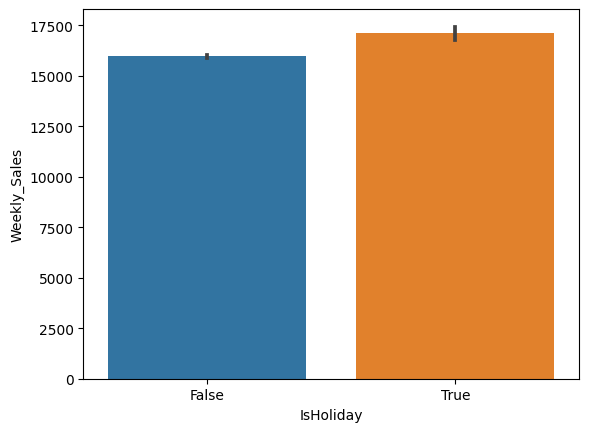

In [20]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [21]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [22]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique() 

133

##### - Agora vamos separar os feriados em 4 tipos: Super bowl, Labor day, Thansksgiving e Christmas dates. ⇩

In [23]:
# - Agora vamos separar os feriados em 4 tipos: Super bowl, Labor day, Thansksgiving e Christmas dates. ⇩
# - Super bowl ⇩
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [24]:
# - Labor day ⇩
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [25]:
# - Thanksgiving ⇩
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [26]:
# - Christmas ⇩
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

##### - Christmas x Weekly_Sales ⇩ 

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

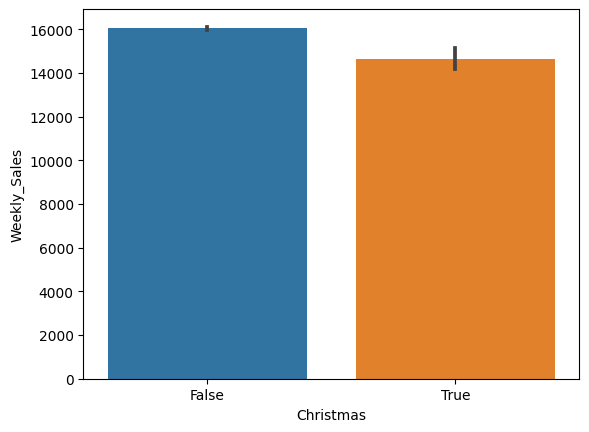

In [27]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df)

##### - Thanksgiving x Weekly_Sales ⇩ 

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

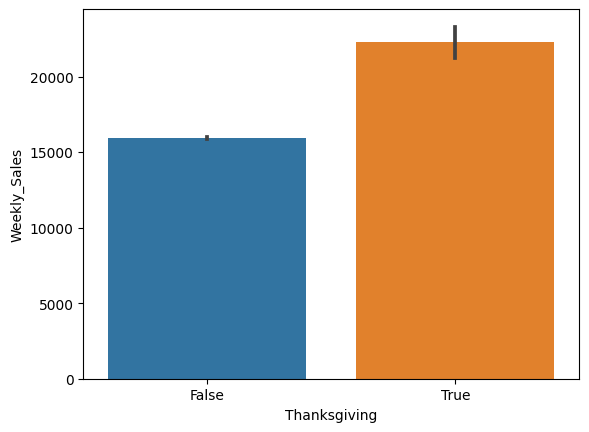

In [28]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df)

##### - Super bowl x Weekly_Sales ⇩ 

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

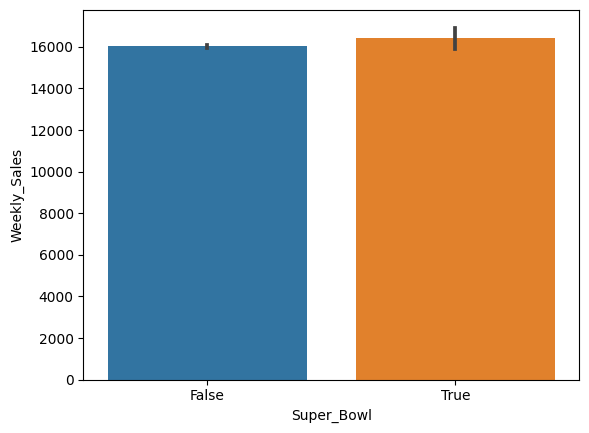

In [29]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df)

##### - Labor Day x Weekly_Sales ⇩ 

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

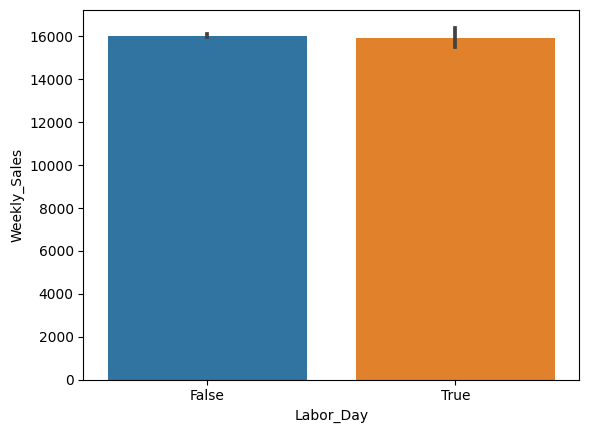

In [30]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df)

In [31]:
# - Formatação com vírgulas para separar milhares e duas casas decimais ⇩ 
mean_sales = df.groupby(['Christmas', 'Type'])['Weekly_Sales'].mean().apply(lambda x: '{:,.2f}'.format(x))
print(mean_sales)

Christmas  Type
False      A       20,174.35
           B       12,301.99
           C        9,570.95
True       A       18,310.17
           B       11,488.99
           C        8,031.52
Name: Weekly_Sales, dtype: object


In [32]:
# - Formatação com vírgulas para separar milhares e duas casas decimais ⇩ 
mean_sales = df.groupby(['Thanksgiving', 'Type'])['Weekly_Sales'].mean().apply(lambda x: '{:,.2f}'.format(x))
print(mean_sales)

Thanksgiving  Type
False         A       20,044.01
              B       12,197.72
              C        9,547.38
True          A       27,397.78
              B       18,733.97
              C        9,696.57
Name: Weekly_Sales, dtype: object


In [33]:
# - Formatação com vírgulas para separar milhares e duas casas decimais ⇩ 
mean_sales = df.groupby(['Labor_Day', 'Type'])['Weekly_Sales'].mean().apply(lambda x: '{:,.2f}'.format(x))
print(mean_sales)

Labor_Day  Type
False      A       20,151.21
           B       12,294.95
           C        9,542.10
True       A       20,004.27
           B       12,084.30
           C        9,893.46
Name: Weekly_Sales, dtype: object


In [34]:
# - Formatação com vírgulas para separar milhares e duas casas decimais ⇩ 
mean_sales = df.groupby(['Super_Bowl', 'Type'])['Weekly_Sales'].mean().apply(lambda x: '{:,.2f}'.format(x))
print(mean_sales)

Super_Bowl  Type
False       A       20,138.06
            B       12,286.74
            C        9,536.11
True        A       20,612.76
            B       12,467.04
            C       10,179.27
Name: Weekly_Sales, dtype: object


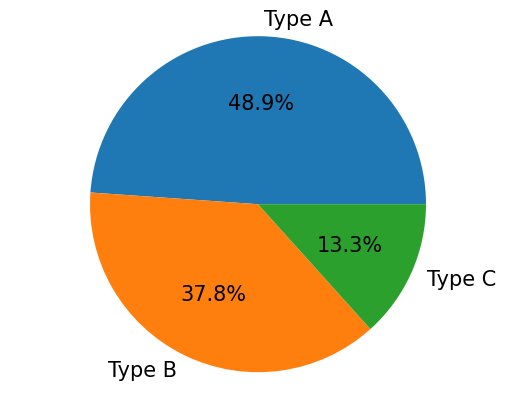

In [35]:
my_data = [48.88, 37.77 , 13.33 ]  
my_labels = 'Type A','Type B', 'Type C' 
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) 
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) 

plt.show()

In [36]:
df.groupby('IsHoliday')['Weekly_Sales'].mean().apply(lambda x: '{:,.2f}'.format(x))

IsHoliday
False    15,952.82
True     17,094.30
Name: Weekly_Sales, dtype: object

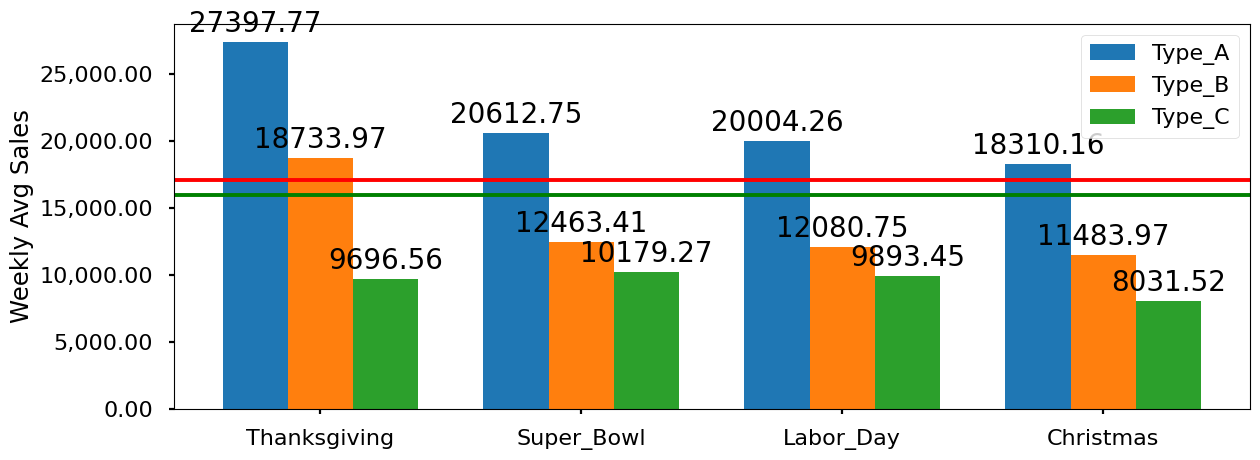

In [37]:
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

formatted_A_means = ["{:,}".format(number) for number in A_means]
formatted_B_means = ["{:,}".format(number) for number in B_means]
formatted_C_means = ["{:,}".format(number) for number in C_means]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 5))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') 
plt.axhline(y=15952.82,color='green') 

# Formatting y-axis labels with commas
def format_with_commas(value, pos):
    return "{:,.2f}".format(value)

y_formatter = FuncFormatter(format_with_commas)
ax.yaxis.set_major_formatter(y_formatter)

fig.tight_layout()

plt.show()

In [38]:
df.sort_values(by='Weekly_Sales', ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
90645,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
337053,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
94393,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
333594,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
131088,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


##### - Type Relation ⇩ 

In [39]:
result = df_store.groupby('Type').describe()['Size'].round(2)
formatted_result = result.applymap('{:,.2f}'.format)
display(formatted_result)

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.00,"177,247.73","49,392.62","39,690.00","155,840.75","202,406.00","203,819.00","219,622.00"
B,17.00,"101,190.71","32,371.14","34,875.00","93,188.00","114,533.00","123,737.00","140,167.00"
C,6.00,"40,541.67","1,304.15","39,690.00","39,745.00","39,910.00","40,774.00","42,988.00"


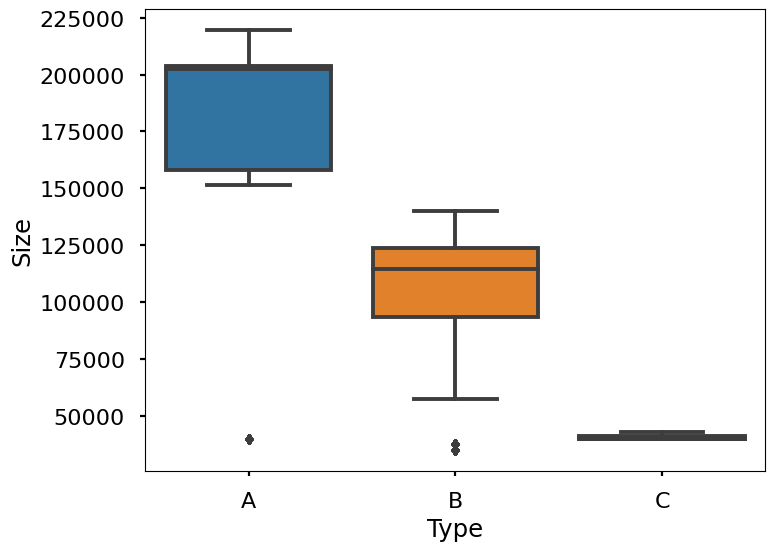

In [40]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers='False')

##### - Markdown ⇩ 

In [41]:
df.isnull().sum() 

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [42]:
df = df.fillna(0) 

In [43]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


##### - Aprofundando a análise da coluna 'Sales' ⇩ 

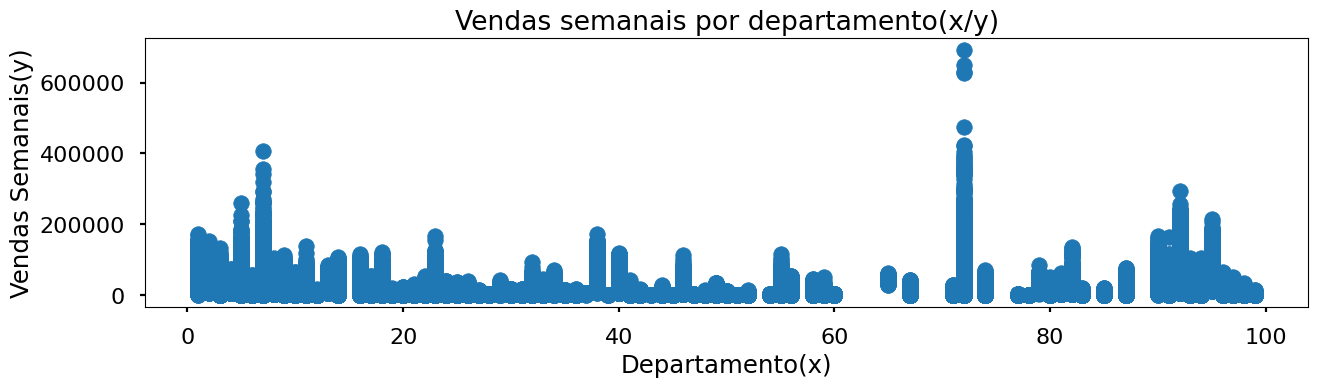

In [44]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,3.5))
plt.title('Vendas semanais por departamento(x/y)')
plt.xlabel('Departamento(x)')
plt.ylabel('Vendas Semanais(y)')
plt.scatter(x, y)
plt.show()

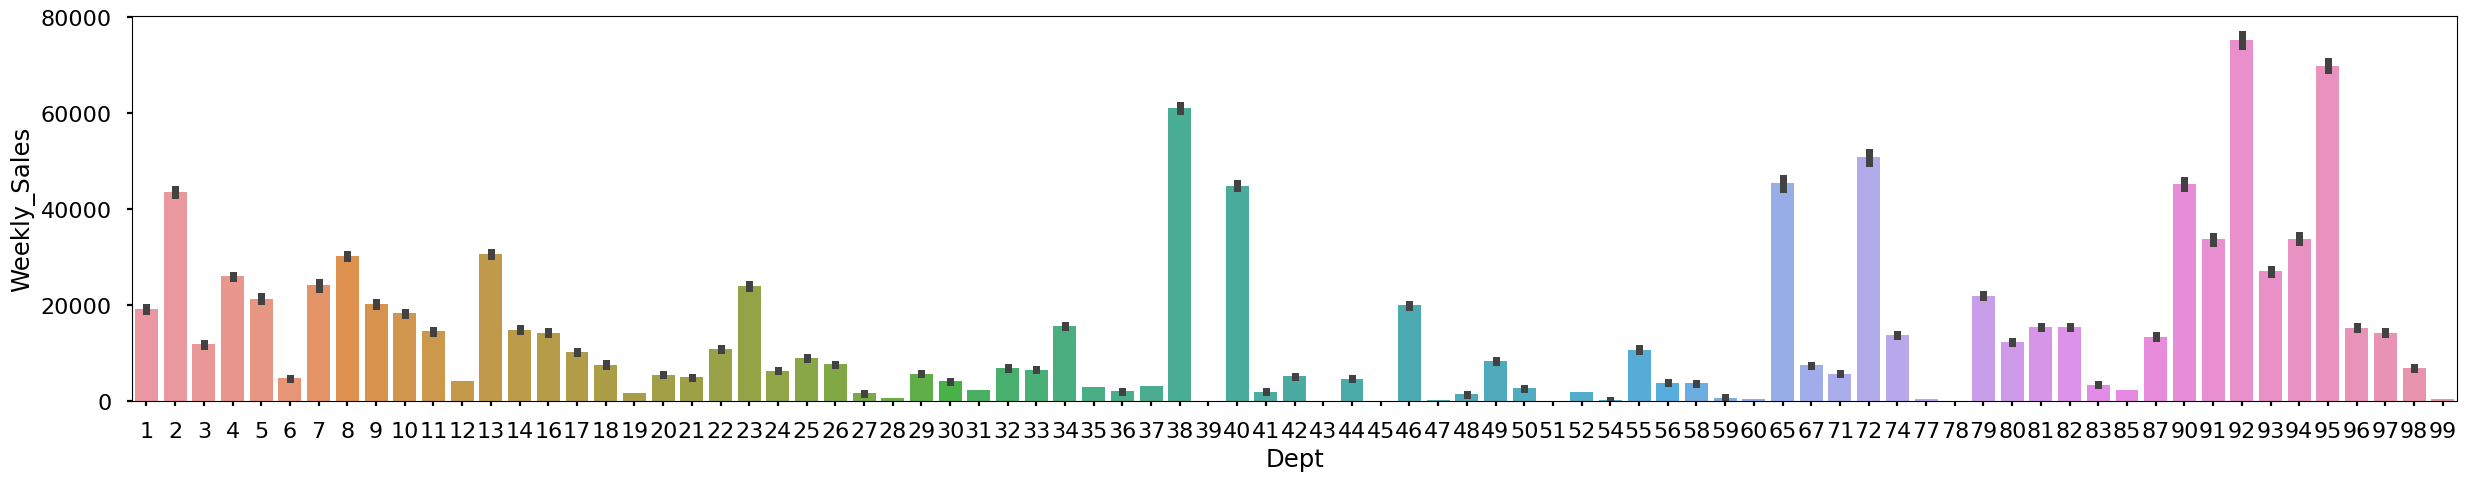

In [45]:
plt.figure(figsize=(30,5))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

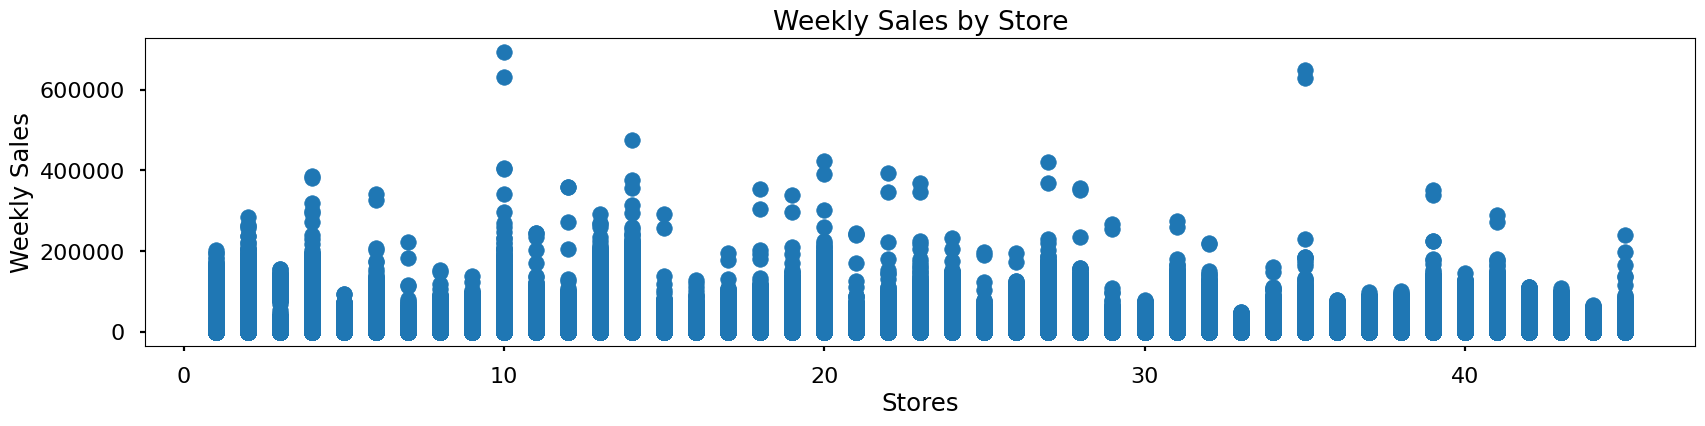

In [46]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(20,4))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

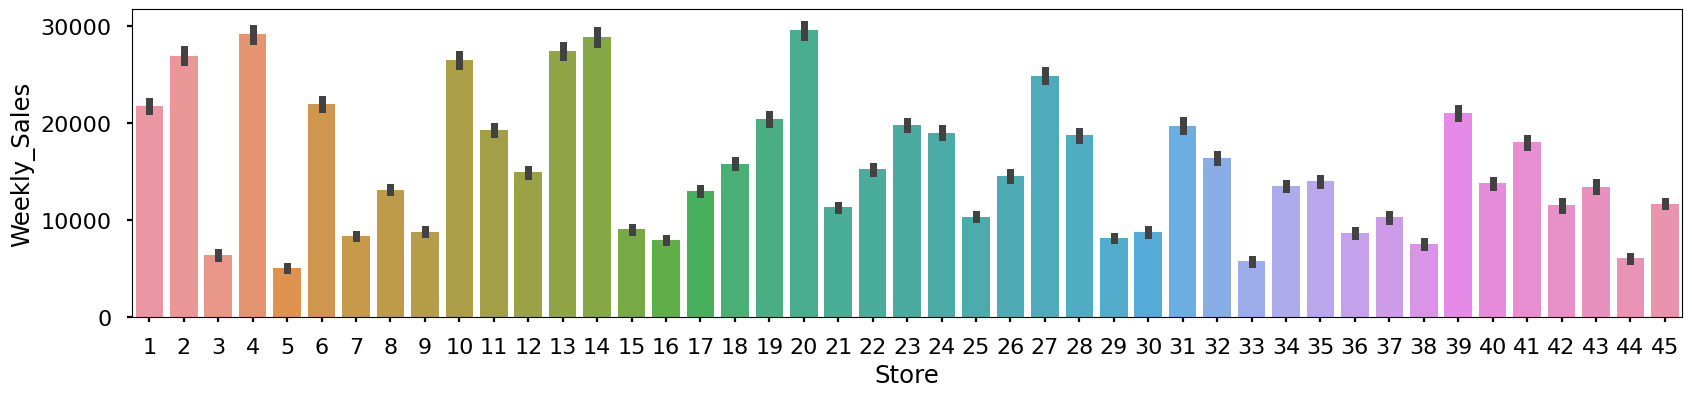

In [47]:
plt.figure(figsize=(20,4))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

##### - Mudando Data pra Datatime e criando novas colunas, afim de melhorar nosso codigo para futuras previsões. ⇩ 

In [49]:
df['Date'] = pd.to_datetime(df['Date'])
df['week'] = df['Date'].dt.week
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

In [50]:
df.groupby('month')['Weekly_Sales'].mean()

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [51]:
df.groupby('year')['Weekly_Sales'].mean()

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='month'>

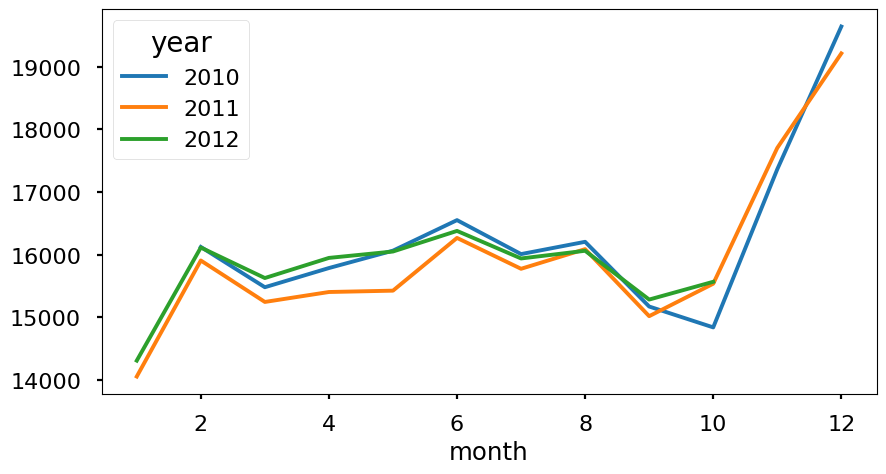

In [54]:
monthly_sales = pd.pivot_table(df, values='Weekly_Sales', columns='year', index='month')
monthly_sales.plot(figsize=(10,5))

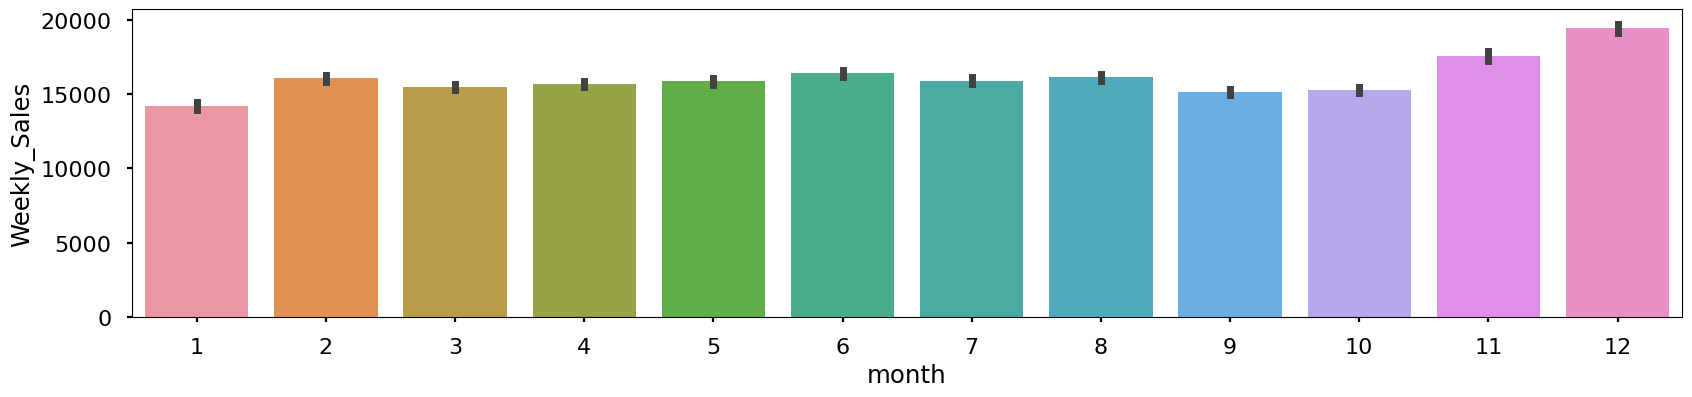

In [61]:
plt.figure(figsize=(20,4))
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

In [62]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head(5)

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='week'>

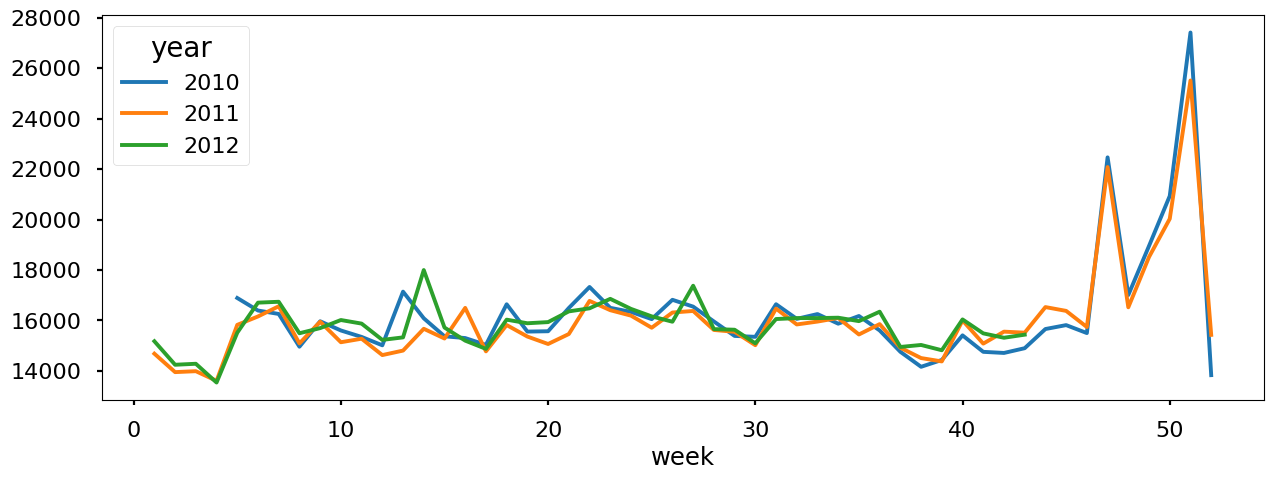

In [66]:
weekly_sales = pd.pivot_table(df, values='Weekly_Sales', columns='year', index='week')
weekly_sales.plot(figsize=(15,5))

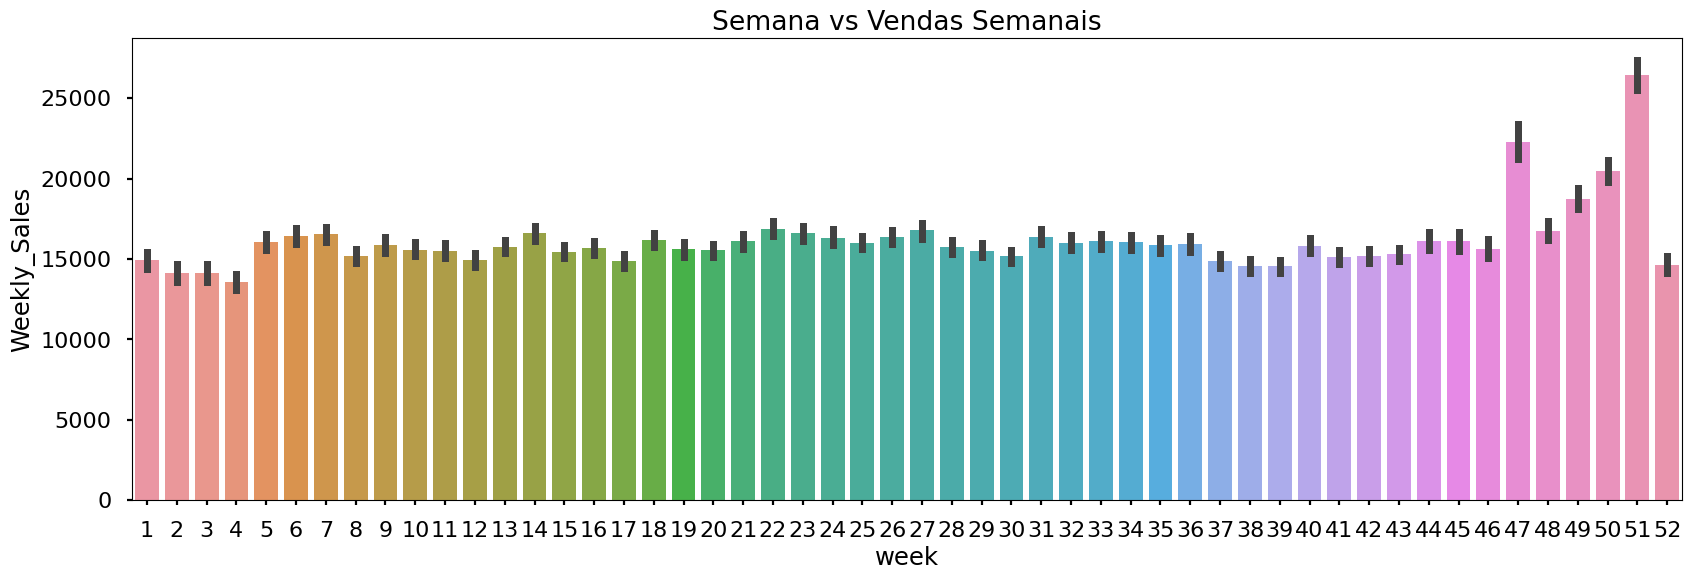

In [69]:
plt.figure(figsize=(20,6))
plt.title('Semana vs Vendas Semanais')
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

##### - Fuel Price, CPI , Unemployment , Temperature Effects. ⇩

<Axes: xlabel='Fuel_Price'>

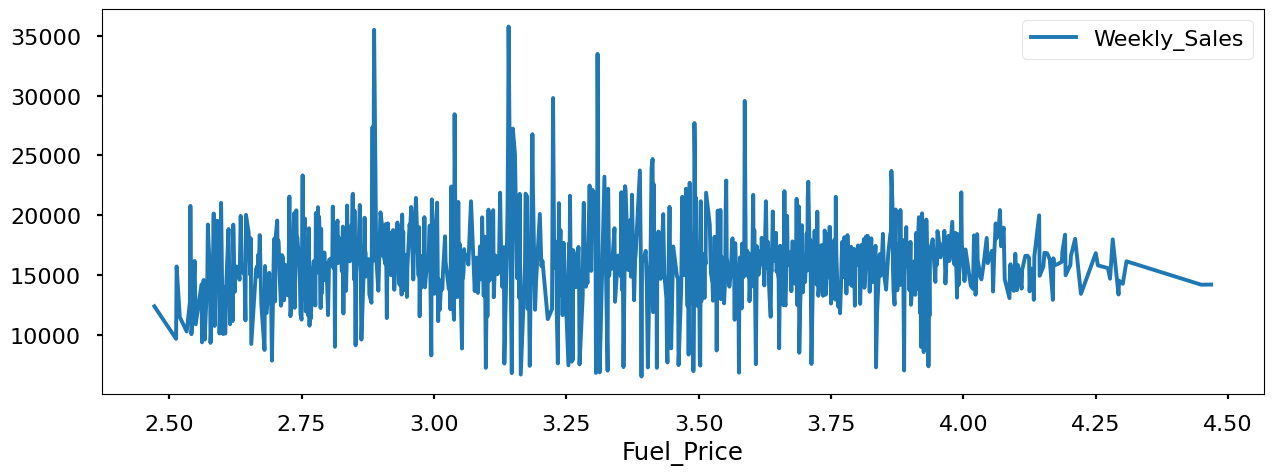

In [71]:
fuel_price =pd.pivot_table(df, values='Weekly_Sales', index='Fuel_Price')
fuel_price.plot(figsize=(15,5))

<Axes: xlabel='Temperature'>

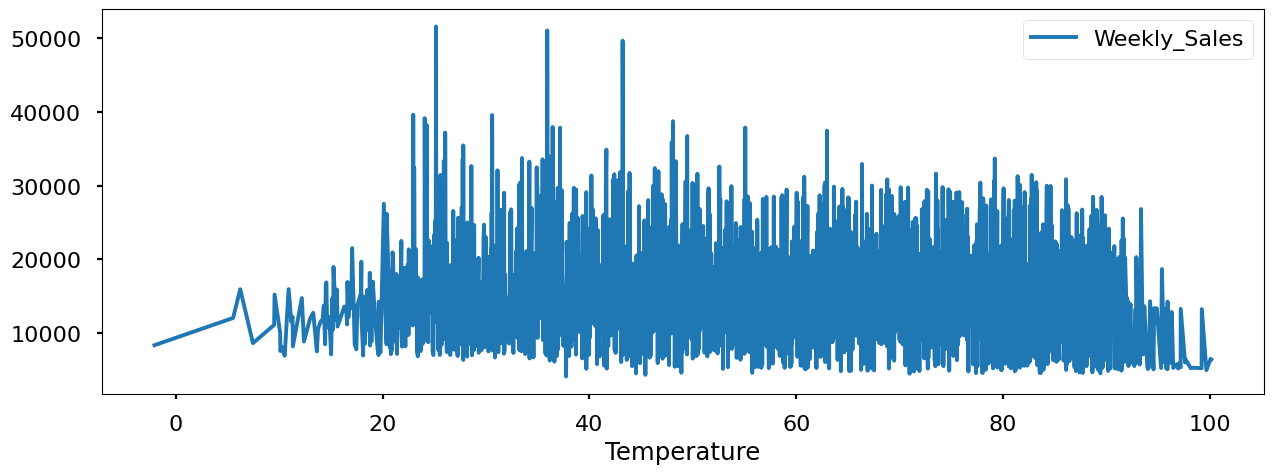

In [73]:
temp = pd.pivot_table(df, values='Weekly_Sales', index='Temperature')
temp.plot(figsize=(15,5))

<Axes: xlabel='CPI'>

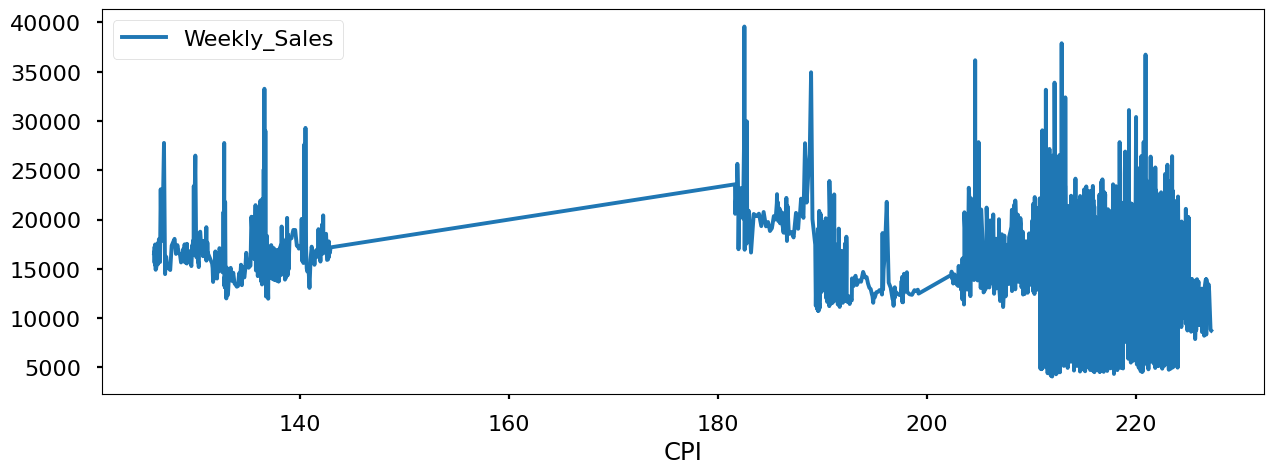

In [74]:
cpi = pd.pivot_table(df, values='Weekly_Sales', index='CPI')
cpi.plot(figsize=(15,5))

<Axes: xlabel='Unemployment'>

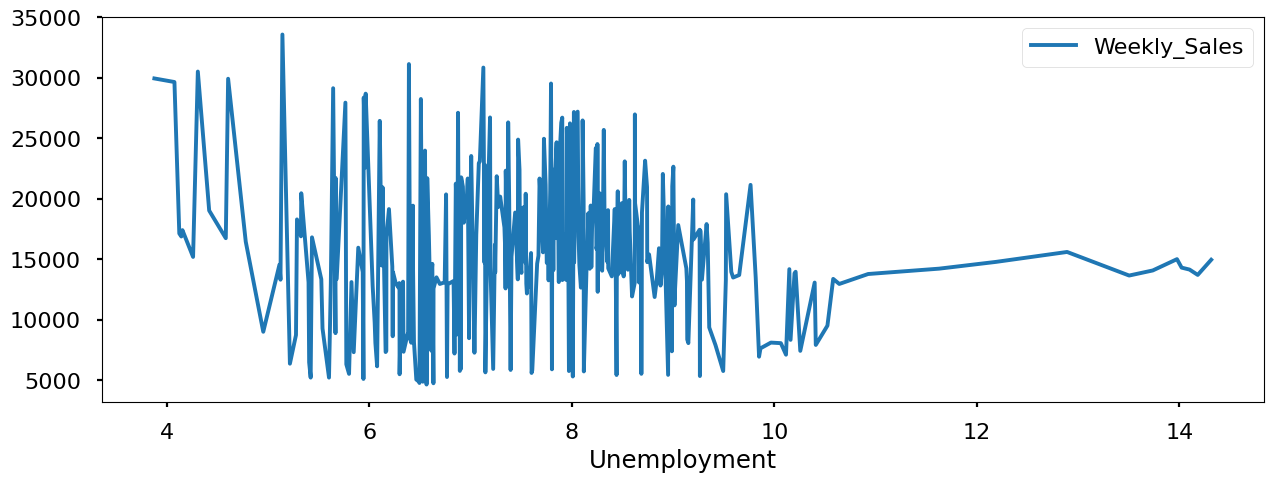

In [75]:
unemployment = pd.pivot_table(df, values='Weekly_Sales', index='Unemployment')
unemployment.plot(figsize=(15,5))

In [76]:
df.to_csv('clean_data.csv')